## Module Imports

In [1]:
include("emulation_functions.jl")
using BenchmarkTools
using CSV
using JLD2
using Dates
using MultivariateStats
import MultivariateStats: reconstruct
using GaussianProcesses
using NCDatasets
using DataFrames
using ForwardDiff
using LinearAlgebra
using NamedArrays
using Plots
using Plots.PlotMeasures
using Optimization
using OptimizationOptimJL
using Statistics
using StatsPlots
using Distributions
using Turing
using .Threads

## Set File Directory
Set the `directory_of_files` variable below to the path leading to your folder containing all the data and emulator files.

In [3]:
# directory where all files are located. If it is this working directory, set this to "./"
directory_of_files = "./"; 
p_names = (:flnr,:slatop,:dleaf,:dsladlai,:leaf_long,:s_vc,:bbbopt,:mbbopt,:smpsc,:smpso,:rholvis,:rholnir,:taulvis,:taulnir,:rhosvis,:rhosnir,:xl,:displar,:z0mr,:vcmaxha,:vcmaxhd,:jmaxha,:jmaxhd,:roota_par,:rootb_par,:grperc)
p_names_dis = (:flnr,:slatop,:leaf_long, :rootb_par)

D = length(p_names_dis)

4

## Load data 

In [5]:
# Dictionaries to make this all neater
output_var_header_names = Dict{String, String}("GPP" => "GPP_NT_VUT_REF", 
                                               "NEE" => "NEE_VUT_REF", 
                                               "LH" => "LE_F_MDS", 
                                               "SH" => "H_F_MDS")
site_names = Dict{String, String}("US_Me2" => "fluxnet_US_Me2_2003_2007", 
                                  "US_Dk3" => "fluxnet_US_Dk3_2003_2007",
                                  "CA_TP4" => "fluxnet_CA_TP4_2003_2007",
                                  "US_Blo" => "fluxnet_US_Blo_2003_2007",
    );

## Load default parameters

In [7]:
p_default=[0.0509,0.01,0.04,0.0006,1.5,20.72,10000,9,-255000,-66000,0.07,0.35,0.05,0.1,0.16,0.39,0.01,0.67,0.055,72000,200000,50000,200000,3,1.25,0.3]
elements = ["flnr","slatop","dleaf","dsladlai","leaf_long","s_vc","bbbopt","mbbopt","smpsc","smpso","rholvis","rholnir","taulvis",
            "taulnir","rhosvis","rhosnir","xl","displar","z0mr","vcmaxha","vcmaxhd","jmaxha","jmaxhd","roota_par","rootb_par","grperc"]
p_hard = (  flnr =      [0.04, 0.3],                         
            slatop =    [0.003, 0.03],
            dleaf =     [0.03, 0.3],
            dsladlai =  [0.0002, 0.0035],
            leaf_long = [1.0, 12.0],
            s_vc =      [16.0,32.0],
            bbbopt =    [16000.0,60000.0],
            mbbopt =    [4.5, 15],
            smpsc =     [-642000.0, -125000.0],
            smpso =     [-125000.0, -17500.0],
            rholvis =   [0.025, 0.25],
            rholnir =   [0.25,0.55],
            taulvis =   [0.005,0.20],
            taulnir =   [0.15,0.45],
            rhosvis =   [0.05,0.30],
            rhosnir =   [0.20,0.75],
            xl =        [-0.5,0.375],
            displar =   [0.6,0.85],
            z0mr =      [0.04,0.09],
            vcmaxha =   [45000.0,90000.0],
            vcmaxhd =   [198000.0, 202000.0],
            jmaxha =    [30000.0,65000.0],
            jmaxhd =    [198000.0, 202000.0],
            roota_par = [2.0,18.0],
            rootb_par = [0.5,6.0],
            grperc =    [0.125,0.375] );

p_hard = [getproperty(p_hard, pn) for pn in propertynames(p_hard)];
p_hard_l = mapreduce(permutedims, vcat, p_hard)[:, 1];
p_hard_u = mapreduce(permutedims, vcat, p_hard)[:, 2];
p_norm = (p_default.- p_hard_l) ./ (p_hard_u .- p_hard_l)

26-element Vector{Float64}:
  0.041923076923076924
  0.25925925925925924
  0.03703703703703704
  0.1212121212121212
  0.045454545454545456
  0.29499999999999993
 -0.13636363636363635
  0.42857142857142855
  0.7485493230174082
  0.5488372093023256
  0.2
  0.3333333333333332
  0.23076923076923078
 -0.1666666666666666
  0.44
  0.3454545454545454
  0.5828571428571429
  0.28000000000000025
  0.3
  0.6
  0.5
  0.5714285714285714
  0.5
  0.0625
  0.13636363636363635
  0.7

## NOTE: 
#### `output_of_interest`
+ "GPP"
+ "NEE"
+ "LH"
+ "SH"


In [9]:
# == SPECIFY THESE PARAMETERS TO SELECT OUTPUT VAR, SITE EMULATOR, AND CALIBRATION SITE OF INTEREST ===
c_site1_to_calibrate_to = "US_Me2"
c_site2_to_calibrate_to = "US_Dk3"
c_site3_to_calibrate_to = "US_Blo"
c_site4_to_calibrate_to = "CA_TP4"
c_site5_to_calibrate_to = "US_NR1"
c_site6_to_calibrate_to = "CA_Qfo"
c_site7_to_calibrate_to = "CA_Obs"
c_site8_to_calibrate_to = "CA_TP1"
c_site9_to_calibrate_to = "CA_TP2"
c_site10_to_calibrate_to = "CA_TP3"

t_site1_to_predict_to = "CA_Qfo"
output_of_interest = "GPP"


"GPP"

In [10]:
#site =  site_names[site_to_calibrate_to]
output = output_var_header_names[output_of_interest]
begin_date = "2003" # Begin date of fluxnet data file (in case this changes in the future)
end_date = "2007" # End data of fluxnet data file (in case this changes in the future)

"2007"

In [11]:
function calculate_10day_average(data0)
    num_years = 5  
    monthday=[10, 10,11,10,10,8,10,10,11,10,10,10,10,10,11,10,10,10,10,10,11,10,10,11,10,10,10,10,10,11,10,10,10,10,10,11];
    monthly_average = Vector{Float64}()
    end_day=0
    for year in 1:num_years
        start_day=end_day+1
        for month in 1:36
            end_day = start_day + monthday[month]-1
            temp=mean(filter(!isnan,data0[start_day:end_day,:]), dims=1)
            push!(monthly_average,temp[1])
            start_day=end_day+1
        end
    end
    println(typeof(monthly_average))
    println(size(monthly_average))
    return monthly_average
end

calculate_10day_average (generic function with 1 method)

In [12]:
data = CSV.read("$(directory_of_files)/fluxnet_$(c_site1_to_calibrate_to)_$(begin_date)_$(end_date)_QC.txt", DataFrame, header=1, delim=",")
y_site1 = Array(data[!, output])
id_1=findall(y_site1.<0)
y_site1[id_1].=0
data = CSV.read("$(directory_of_files)/fluxnet_$(c_site2_to_calibrate_to)_$(begin_date)_$(end_date)_QC.txt", DataFrame, header=1, delim=",")
y_site2 = Array(data[!, output])
id_2=findall(y_site2.<0)
y_site2[id_2].=0
data = CSV.read("$(directory_of_files)/fluxnet_$(c_site3_to_calibrate_to)_$(begin_date)_$(end_date)_QC.txt", DataFrame, header=1, delim=",")
y_site3 = Array(data[!, output])
id_3=findall(y_site3.<0)
y_site3[id_3].=0
data = CSV.read("$(directory_of_files)/fluxnet_$(c_site4_to_calibrate_to)_$(begin_date)_$(end_date)_QC.txt", DataFrame, header=1, delim=",")
y_site4 = Array(data[!, output]);
id_4=findall(y_site4.<0)
y_site4[id_4].=0
data = CSV.read("$(directory_of_files)/fluxnet_$(c_site5_to_calibrate_to)_$(begin_date)_$(end_date)_QC.txt", DataFrame, header=1, delim=",")
y_site5 = Array(data[!, output]);
id_5=findall(y_site5.<0)
y_site5[id_5].=0

276-element view(::Vector{Float64}, [1, 2, 3, 5, 7, 8, 10, 13, 15, 19  …  1803, 1805, 1808, 1809, 1813, 1816, 1819, 1823, 1824, 1825]) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

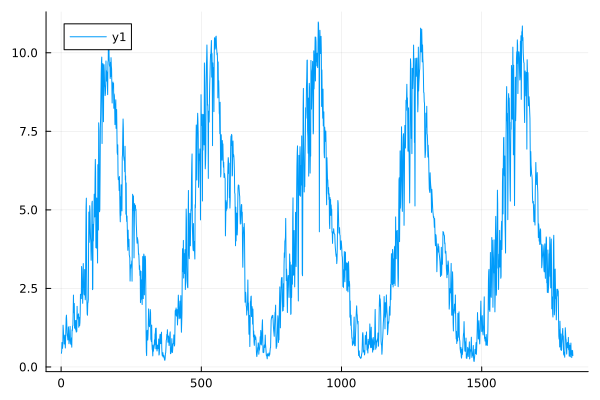

In [13]:
ensembles0 = CSV.read("./parameters_normalized_emulator_result_US_Me2_GPP_200_4par.txt", DataFrame; header = false, transpose=true);
GPP1 = Matrix(ensembles0)'*24*3600
ensembles_mGPP1 = mean(GPP1, dims=1)
GPP_Me2_be_200=GPP1[:,144]
plot(GPP_Me2_be_200)

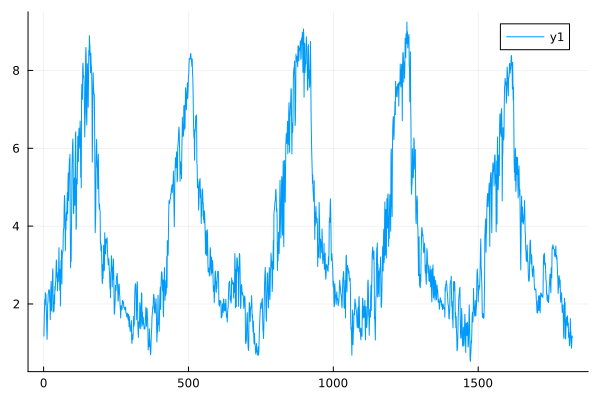

In [14]:
ensembles0 = CSV.read("./parameters_normalized_emulator_result_US_Blo_GPP_200_4par.txt", DataFrame; header = false, transpose=true);
GPP1 = Matrix(ensembles0)'*24*3600
ensembles_mGPP1 = mean(GPP1, dims=1)
GPP_Blo_be_200=GPP1[:,8]
plot(GPP_Blo_be_200)

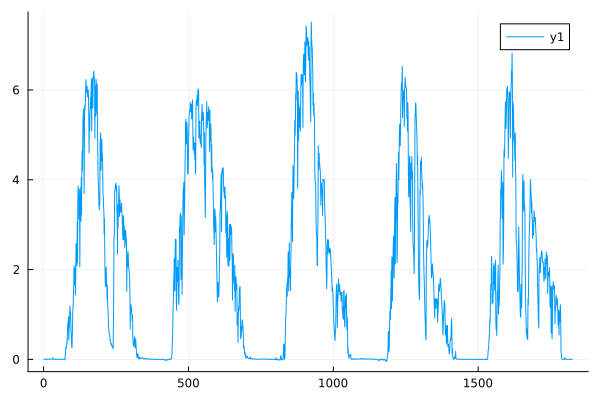

In [15]:
ensembles0 = CSV.read("./parameters_normalized_emulator_result_US_NR1_GPP_200_4par.txt", DataFrame; header = false, transpose=true);
GPP1 = Matrix(ensembles0)'*24*3600
ensembles_mGPP1 = mean(GPP1, dims=1)
GPP_NR1_be_200=GPP1[:,32]
plot(GPP_NR1_be_200)

In [16]:
GPP_01 = calculate_10day_average(y_site1)
GPP_02 = calculate_10day_average(y_site2)
GPP_03 = calculate_10day_average(y_site3)
GPP_04 = calculate_10day_average(y_site4)
GPP_05 = calculate_10day_average(y_site5)

Vector{Float64}
(180,)
Vector{Float64}
(180,)
Vector{Float64}
(180,)
Vector{Float64}
(180,)
Vector{Float64}
(180,)


180-element Vector{Float64}:
 0.011666100000000002
 0.05504100000000001
 0.08490109090909091
 0.0721679
 0.10315479999999999
 0.013480250000000001
 0.051937699999999996
 0.1961236
 0.11539490909090909
 0.1596205
 0.6403306
 1.3749998
 1.1542035
 ⋮
 5.072827000000001
 4.654305000000001
 3.777454
 2.79505
 1.4432819
 1.2684326363636365
 0.7897079999999999
 0.4319197
 0.12045179999999997
 0.0471526
 0.0492616
 0.02989563636363636

In [17]:
a1=std(y_site1-GPP_Me2_be_200)
a3=std(y_site3-GPP_Blo_be_200)
a5=std(y_site5-GPP_NR1_be_200)
println([a1,a3,a5])

[1.4239187436784906, 2.1325612114397337, 1.4995745416796258]


In [18]:
iid_normal_noise1 = a1*randn(1825)
GPP_01_be=calculate_10day_average(GPP_Me2_be_200+iid_normal_noise1)
iid_normal_noise3 = a3*randn(1825)
GPP_03_be=calculate_10day_average(GPP_Blo_be_200+iid_normal_noise3)
iid_normal_noise5 = a5*randn(1825)
GPP_05_be=calculate_10day_average(GPP_NR1_be_200+iid_normal_noise5)

Vector{Float64}
(180,)
Vector{Float64}
(180,)
Vector{Float64}
(180,)


180-element Vector{Float64}:
  0.8143190732030563
 -0.19755443626807584
  0.5255870670812226
 -0.27538105486236947
  0.30362128614323314
 -0.5026225680835482
  0.5106982638389361
 -0.15899426172382897
  1.3604289091787398
  0.572959862133192
  2.27719499046026
  2.7559064622733813
  3.1146717407475486
  ⋮
  2.0103353971208056
  2.604381985747195
  2.5777785384840035
  1.6715039333293675
  0.958828631008781
  0.8248529221914164
  1.0161940399641616
  1.151417982353328
  0.0133270681346084
  0.1987552349336011
  0.11202177468901567
  0.43150182766261663

## Load emulator (all GPs used in reconstruction)

In [20]:
emulator_filename1 = "$(directory_of_files)/emulator_$(output_of_interest)_$(c_site1_to_calibrate_to)_200_4par.jld2";
@load emulator_filename1 array_GP pca_fit μ_z σ_z
emulator_components1 = (GPs = array_GP, T_PCA = pca_fit, μ_z = μ_z, σ_z = σ_z);
emulator_filename3 = "$(directory_of_files)/emulator_$(output_of_interest)_$(c_site3_to_calibrate_to)_200_4par.jld2";
@load emulator_filename3 array_GP pca_fit μ_z σ_z
emulator_components3 = (GPs = array_GP, T_PCA = pca_fit, μ_z = μ_z, σ_z = σ_z);
emulator_filename5 = "$(directory_of_files)/emulator_$(output_of_interest)_$(c_site5_to_calibrate_to)_200_4par.jld2";
@load emulator_filename5 array_GP pca_fit μ_z σ_z
emulator_components5 = (GPs = array_GP, T_PCA = pca_fit, μ_z = μ_z, σ_z = σ_z);

┌ Warning: the following fields are present in type PDMats.PDMat{Float64, Matrix{Float64}} saved in the file but not present in the type in the workspace:
│ 
│ dim,
│ 
│ Data in these fields will not be accessible
└ @ JLD2 C:\Users\IGB\.julia\packages\JLD2\SgtOb\src\data\reconstructing_datatypes.jl:241
┌ Warning: the following fields are present in type PDMats.PDMat{Float64, Matrix{Float64}} saved in the file but not present in the type in the workspace:
│ 
│ dim,
│ 
│ Data in these fields will not be accessible
└ @ JLD2 C:\Users\IGB\.julia\packages\JLD2\SgtOb\src\data\reconstructing_datatypes.jl:241
┌ Warning: the following fields are present in type PDMats.PDMat{Float64, Matrix{Float64}} saved in the file but not present in the type in the workspace:
│ 
│ dim,
│ 
│ Data in these fields will not be accessible
└ @ JLD2 C:\Users\IGB\.julia\packages\JLD2\SgtOb\src\data\reconstructing_datatypes.jl:241


## Bayesian Parameter Calibration

## Create probabilistic model

Our likelihood looks like linear regression and features discrepency terms $\beta_0$ and $\beta_1$ in addition to noise term $\epsilon$.

### Likelihood: 
$$y \sim \beta_1 GP(\theta) + \epsilon, \qquad $$
$$\epsilon \stackrel{iid}{\sim} N(0,\sigma^2)$$

for now we assume a known $\sigma$, but we could estimate this parameter as well. $y$ is any quantity of interest predicted by the GP, $\theta$ are the model parameters (from the ELM model, the set of 26 params)

### Priors: 

$$\theta \sim p(\theta)$$ 
$$p(\theta) = Normal(0.5,0.25)$$
$$\log(\sigma) \sim N(\log 1, ((\log 2)/2)^2)$$

And I chose Normal priors for the regression parameters and LogNormal for the standard deviation. 


Define Prior distributions

ZJ: I change the priors and define the prob_model for each site, as the emulators are different

### Site 1

In [21]:
#try other priors and define the model (emulator) outside for final validation (sample observation & simulated observation)
function priors(num_params)
    return filldist( Truncated(Normal(0.5,0.25), 0,1), num_params)
end
model_1(θ,N_PCA)= calibration_emulator1(θ, emulator_components1, N_PCA);

Q(y)=mean(y)

Q (generic function with 1 method)

In [22]:
@model function prob_model_1(y, num_params, N_PCA)
    # Define the priors
    p ~ priors(num_params)
    β_1 ~ Uniform(0.9,1.1)
    σ ~ LogNormal(log(1), log(2)/2)
    θ = reshape(p, 1,length(p)) # GP is very picky about dimensions, so we need to reshape here
    m=model_1(θ,N_PCA)
    y ~ MvNormal(β_1*m, σ^2*I )
    return Q(m)
end 

prob_model_1 (generic function with 2 methods)

In [ ]:
alg = NUTS(1000,0.65)
strategy = MCMCSerial()
N_param=4
N_sample =5000
N_chain = 5

model = prob_model_1(GPP_01, N_param, 12)
@time chain1 = Turing.sample(model, alg, strategy, N_sample, N_chain; progress=true)
chain1 = replacenames(chain1, Dict("p[$i]" => p_names_dis[i] for i in 1:D))
@save "US_Me2_GPP_fluxnet_nobeta0_5000_5_4par_180day.jld2" chain1

### Site 3

In [23]:
#try other priors and define the model (emulator) outside for final validation (sample observation & simulated observation)
function priors(num_params)
    return filldist( Truncated(Normal(0.5,0.25), 0,1), num_params)
end
model_3(θ,N_PCA)= calibration_emulator1(θ, emulator_components3, N_PCA);

Q(y)=mean(y)

Q (generic function with 1 method)

In [24]:
@model function prob_model_3(y, num_params, N_PCA)
    # Define the priors
    p ~ priors(num_params)
    β_1 ~ Uniform(0.9,1.1)
    σ ~ LogNormal(log(1), log(2)/2)
    
    θ = reshape(p, 1,length(p)) # GP is very picky about dimensions, so we need to reshape here
    m=model_3(θ,N_PCA)
    y ~ MvNormal(β_1*m, σ^2*I )
    return Q(m)
end 

prob_model_3 (generic function with 2 methods)

In [ ]:
alg = NUTS(1000,0.65)
strategy = MCMCSerial()
N_param=4
N_sample =5000
N_chain = 5

model = prob_model_3(GPP_03, N_param, 12)
@time chain3 = Turing.sample(model, alg, strategy, N_sample, N_chain; progress=true)
chain3 = replacenames(chain3, Dict("p[$i]" => p_names_dis[i] for i in 1:D))
@save "US_Blo_GPP_fluxnet_nobeta0_5000_5_4par_180day.jld2" chain3

### site 5

In [25]:
#try other priors and define the model (emulator) outside for final validation (sample observation & simulated observation)
function priors(num_params)
    return filldist( Truncated(Normal(0.5,0.25), 0,1), num_params)
end
model_5(θ,N_PCA)= calibration_emulator1(θ, emulator_components5, N_PCA);

Q(y)=mean(y)

Q (generic function with 1 method)

In [26]:
@model function prob_model_5(y, num_params, N_PCA)
    # Define the priors
    p ~ priors(num_params)
    β_1 ~ Uniform(0.9,1.1)
    σ ~ LogNormal(log(1), log(2)/2)
    
    θ = reshape(p, 1,length(p)) # GP is very picky about dimensions, so we need to reshape here
    m=model_5(θ,N_PCA)
    y ~ MvNormal(β_1*m, σ^2*I )
    return Q(m)
end 

prob_model_5 (generic function with 2 methods)

In [ ]:
alg = NUTS(1000,0.65)
strategy = MCMCSerial()
N_param=4
N_sample =5000
N_chain = 5

model = prob_model_5(GPP_05, N_param, 12)
@time chain5 = Turing.sample(model, alg, strategy, N_sample, N_chain; progress=true)
chain5 = replacenames(chain5, Dict("p[$i]" => p_names_dis[i] for i in 1:D))
@save "US_NR1_GPP_fluxnet_nobeta0_5000_5_4par_180day.jld2" chain5

## Posterior predictions / observing system simulation experiments (OSSEs)

OSSE parameter sampling from posterior distributions

In [28]:
N_samp0 = 1000

1000

In [29]:
@load "US_Me2_GPP_fluxnet_nobeta0_5000_5_4par_180day.jld2"  chain1
achain1=Array(chain1)
@load "US_Blo_GPP_fluxnet_nobeta0_5000_5_4par_180day.jld2"  chain3
achain3=Array(chain3)
@load "US_NR1_GPP_fluxnet_nobeta0_5000_5_4par_180day.jld2" chain5
achain5=Array(chain5)

25000×6 Matrix{Float64}:
 0.025561    0.746765  0.537742  0.328737  1.09537  1.3965
 0.0383607   0.844635  0.525523  0.282448  1.06321  1.20763
 0.0394344   0.869327  0.495713  0.437801  1.04588  1.29526
 0.0394344   0.869327  0.495713  0.437801  1.04588  1.29526
 0.0393717   0.758942  0.48558   0.242904  1.09836  1.38749
 0.0193472   0.878036  0.667117  0.438522  1.09366  1.31791
 0.00292902  0.863298  0.499287  0.764423  1.06987  1.32406
 0.0455804   0.80422   0.618602  0.321383  1.08202  1.39407
 0.0929966   0.865503  0.408886  0.140684  1.09422  1.35751
 0.0475939   0.831354  0.508866  0.231039  1.09363  1.34069
 0.0191645   0.791618  0.564466  0.518488  1.08352  1.33505
 0.00462229  0.817051  0.47906   0.29582   1.08924  1.29125
 0.00735685  0.840284  0.710548  0.62747   1.09639  1.30047
 ⋮                                                  ⋮
 0.00776518  0.893571  0.526102  0.584974  1.09562  1.17557
 0.041208    0.871105  0.493268  0.654134  1.09746  1.41164
 0.0188868   0.873782 

In [31]:
N_param=4
chain_site1_prior = Turing.sample(prob_model_1(GPP_01,N_param,12), Prior(), 5000)
chain_site1_prior = replacenames(chain_site1_prior, Dict("p[$n]" => p_names_dis[n] for n in 1:D))

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06


Chains MCMC chain (5000×7×1 Array{Float64, 3}):

Iterations        = 1:1:5000
Number of chains  = 1
Samples per chain = 5000
Wall duration     = 22.62 seconds
Compute duration  = 22.62 seconds
parameters        = flnr, slatop, leaf_long, rootb_par, β_1, σ
internals         = lp

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

        flnr    0.5031    0.2181     0.0031    0.0028   4867.3604    0.9998    ⋯
      slatop    0.4984    0.2210     0.0031    0.0037   5042.9114    1.0010    ⋯
   leaf_long    0.4962    0.2220     0.0031    0.0034   4823.6771    0.9999    ⋯
   rootb_par    0.5025    0.2214     0.0031    0.0027   5132.5567    0.9999    ⋯
         β_1    1.0004    0.0578     0.0008    0.0007   4505.4901    0.9998    ⋯
           σ    1.0629    0.3818     0.0054    0.0062   4421.1534    1.0000    ⋯
                                                    

In [33]:
p_samp1 = achain1[Turing.sample(1:size(achain1,1), N_samp0),:]
p_samp3 = achain3[Turing.sample(1:size(achain1,1), N_samp0),:]
p_samp5 = achain5[Turing.sample(1:size(achain1,1), N_samp0),:]

1000×6 Matrix{Float64}:
 0.0173386    0.877639  0.532837  0.4857     1.09998  1.20115
 0.0215699    0.906868  0.539587  0.41516    1.09791  1.28108
 0.0859448    0.788704  0.500942  0.126316   1.09858  1.22204
 0.0212317    0.868508  0.563316  0.44925    1.08858  1.20928
 0.0124187    0.899727  0.571196  0.498652   1.0799   1.27481
 0.089217     0.786952  0.514511  0.126557   1.06277  1.32887
 0.0878968    0.987107  0.79854   0.243618   1.07659  1.33308
 0.000235227  0.860047  0.501553  0.525477   1.06074  1.34517
 0.0709099    0.840854  0.577602  0.0624551  1.09248  1.28435
 0.0148058    0.836877  0.55655   0.586858   1.08876  1.28757
 0.0292643    0.833156  0.55906   0.392673   1.06625  1.2724
 0.0124402    0.887218  0.545157  0.731184   1.0894   1.36312
 0.011483     0.875885  0.505746  0.463508   1.07799  1.24353
 ⋮                                                    ⋮
 0.0406847    0.817779  0.644982  0.291032   1.09789  1.35376
 0.0409135    0.816934  0.568908  0.297651   1.0911  

In [34]:
achain0 = Array(chain_site1_prior)
p_samp0 = achain0[Turing.sample(1:size(achain0,1), N_samp0),:]

1000×6 Matrix{Float64}:
 0.555542   0.389528  0.618993     0.580462   0.948117  0.682681
 0.708465   0.151211  0.843807     0.565137   0.92162   0.890821
 0.38335    0.310254  0.000579114  0.429908   1.0999    0.81541
 0.384285   0.53544   0.23759      0.41118    1.01893   1.56984
 0.446372   0.546666  0.493774     0.0477462  0.914995  0.764013
 0.437559   0.834289  0.677608     0.180768   0.900206  0.720274
 0.733553   0.553436  0.66927      0.275255   1.02043   1.22104
 0.0214226  0.540413  0.729956     0.398302   0.980441  1.57184
 0.238772   0.269377  0.696203     0.313397   0.988613  1.50138
 0.720866   0.608962  0.86166      0.530746   1.06981   0.986127
 0.461678   0.934452  0.339037     0.326027   0.918515  0.763406
 0.638253   0.896343  0.482638     0.567606   1.01712   0.901603
 0.689886   0.421229  0.306747     0.390023   1.08443   1.07442
 ⋮                                                      ⋮
 0.641162   0.598865  0.437056     0.20438    0.959934  0.815578
 0.807462   0.

In [35]:
function simulate_observations(N, samples, model,N_PCA)
    N_samp = size(samples,1)
    y_sim = zeros(N, N_samp)
    @threads for i = 1:N_samp
       y_sim[:,i] .= sample_observation(samples[i,:], model,N_PCA)
    end
    y_sim
end

simulate_observations (generic function with 1 method)

In [36]:
using Statistics
using Distributions

# Define the function to calculate the 95% confidence interval
function confidence_interval(data::Vector{Float64}, confidence_level::Float64=0.05)
    # Sample mean
    mean_value = mean(data)

    # Sample standard deviation
    std_dev = std(data)

    # Sample size
    n = length(data)

    # Standard error of the mean
    sem = std_dev / sqrt(n)

    # For the specified confidence interval, the critical value from the t-distribution
    # Degrees of freedom: n - 1
    df = n - 1
    alpha = 1 - confidence_level
    t_critical = quantile(TDist(df), 1 - alpha / 2)

    # Margin of error
    margin_of_error = t_critical * sem

    # Confidence interval
    #lower_bound = mean_value - margin_of_error
    #upper_bound = mean_value + margin_of_error
    lower_bound = quantile(data,0.025)
    upper_bound = quantile(data,0.975)
    
    

    return (lower_bound, upper_bound)
end

confidence_interval (generic function with 2 methods)

In [37]:
# Define a function to calculate RMSE
function rmse(actual, predicted)
    n = length(actual)
    sqrt(sum((actual .- predicted).^2) / n)
end

rmse (generic function with 1 method)

In [42]:
# Define a function to calculate RMSE, NRMSE, and PRMSE
function rmse(actual, predicted; method="percentage")
    n = length(actual)
    rmse_value = sqrt(sum((actual .- predicted).^2) / n)

    if method == "range"
        # Normalized by range (max - min)
        norm_rmse = rmse_value / (maximum(actual) - minimum(actual))
    elseif method == "percentage"
        # Normalized by mean (percentage RMSE)
        norm_rmse = (rmse_value / mean(actual)) 
    else
        error("Invalid method. Choose 'range' or 'percentage'.")
    end

    return norm_rmse
end

rmse (generic function with 1 method)

In [43]:
function r_squared(actual, predicted)
    # 计算均方和
    ss_total = sum((actual .- mean(actual)).^2)
    ss_residual = sum((actual .- predicted).^2)
    r2 = 1 - (ss_residual / ss_total)
    return r2
end

r_squared (generic function with 1 method)

In [44]:
ELM_Me2 = Dataset("US_Me2_GPP_g0001_g1300_2003_2007_res05.nc")
t = ELM_Me2["time"]
time1=year.(t)+dayofyear.(t)/365;

In [45]:
using GLMakie
using CairoMakie

In [46]:
fig = Figure(size= (900, 600));

In [47]:
function sample_observation(sample, model,N_PCA)  
    σ = sample[6] 
    β_1=sample[5]
    p = sample[1:4]
    θ = reshape(p, 1, length(p))
    m = model_1(θ,N_PCA)
    err=a1*randn(length(m))
    y = β_1*m +err
end

sample_observation (generic function with 1 method)

In [50]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp1, model_1, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end

xvalues = [2004, 2006, 2008]
xlabels = ["", "", ""]

# Create figure and axis
#l = fig[1, 1] = GridLayout()
ax1 = Axis(fig[1, 1], xlabel = "", ylabel = "US-Me2",title="US-Me2",xticks=(xvalues, xlabels))
CairoMakie.ylims!(ax1, -5, 15)
# Add plots

p2=band!(ax1, time1[15:10:1805], ci[:, 1], ci[:, 2], color = (:pink, 1))
# Add mean line
p4=lines!(ax1, time1[15:10:1805], GPP_01_be, color = :blue, linewidth = 4, label = "BE+noise")
p3=lines!(ax1, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth = 2, label = "mean")
# Add scatter plots
p5=GLMakie.scatter!(ax1, time1[15:10:1805], GPP_01,  markersize=6,color = :green, label = "FLUXNET")
rmse_value = rmse(GPP_01, y_sim_1_1_m)
text!(ax1, 2003, 13, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
r2 = cor(GPP_01, y_sim_1_1_m)

legend=Legend(fig,[p2,p3,p4,p5], ["95% interval","mean","best estimate","FLUXNET"],tellheight = false, halign =:left, valign =:top, orientation = :horizontal, framevisible = false)
fig[4,2] = legend
legend.width = Relative(1.2)
fig[1,1]=ax1

Axis with 5 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Scatter{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


In [52]:
y_sim_1_1_prior = simulate_observations(180, p_samp0, model_1, 12)

180×1000 Matrix{Float64}:
  2.94847   4.77593   1.13995   -1.80991   …   1.59748    2.97572   3.67364
  3.12367   4.36968  -0.314185   0.936606      0.771596   1.76      4.28581
  4.01232   5.44293   1.75459    0.270472     -1.96884    3.19407   3.65862
  3.52247   6.66544   4.49983    2.18548       2.98032    3.60262   3.6787
  3.02233   5.92529   2.78158    5.09979       3.46086    2.67718   5.40961
  7.02028  10.5081    5.01036    2.62859   …   2.92983    2.63613   4.68111
  5.69841   7.09247   4.26934    3.07874       3.75836    2.91581   3.71874
  7.0347    9.84931   4.7126     4.43614       2.73474    7.05784   6.65035
 10.3462   12.593     4.89633    7.70689       5.73322    6.84758   8.73162
 10.0601   13.4892    3.86014    6.7092        4.11287    6.08904  10.9382
 12.6922   14.7557    5.95782    6.70135   …   4.0413     6.75014  12.9881
 13.3641   14.1942    6.40341    6.47021       7.25302    9.64656  11.1499
 13.536    17.594     6.07744    9.59258       5.52755   11.5172  

In [53]:
function sample_observation(sample, model,N_PCA)  
    σ = sample[6] 
    β_1=sample[5]
    p = sample[1:4]
    θ = reshape(p, 1, length(p))
    m = model_1(θ,N_PCA)
    err=a1*randn(length(m))
    y = β_1*m +err
end
y_sim_1_1 = simulate_observations(180, p_samp1, model_1, 12)
y_sim_1_1_prior = simulate_observations(180, p_samp0, model_1, 12)
function sample_observation(sample, model,N_PCA)  
    σ = sample[6] 
    β_1=sample[5]
    p = sample[1:4]
    θ = reshape(p, 1, length(p))
    m = model_3(θ,N_PCA)
    err=a3*randn(length(m))
    y = β_1*m +err
end
y_sim_3_3 = simulate_observations(180, p_samp3, model_3, 12)
y_sim_3_3_prior = simulate_observations(180, p_samp0, model_3, 12)
function sample_observation(sample, model,N_PCA)  
    σ = sample[6] 
    β_1=sample[5]
    #β_0=sample[5]
    p = sample[1:4]
    θ = reshape(p, 1, length(p))
    m = model_5(θ,N_PCA)
    err=a5*randn(length(m))
    y = β_1*m +err
end
y_sim_5_5 = simulate_observations(180, p_samp5, model_5, 12)
y_sim_5_5_prior = simulate_observations(180, p_samp0, model_5, 12)

180×1000 Matrix{Float64}:
  2.81905     0.503149     0.913173  …   4.06797   -2.68233     2.16288
  0.344991    0.432268     2.97093       0.184838  -0.381632    1.02434
  0.695753    0.426838    -1.07441      -0.808972   0.352131   -2.0803
 -0.875578    1.02037     -0.77322      -2.77197    0.0359793   2.56218
 -2.21239    -0.198934     0.84462       0.923154  -0.995502    2.03287
  0.0464736  -2.28346     -1.79662   …   1.56093   -1.49773    -0.791771
  1.11897     1.45841      1.19962      -0.366505  -0.538246   -0.030441
  2.58953     3.00569      2.0563       -1.10364    1.22789     1.50188
  0.749134    5.25541      1.21459       0.243116   2.77314     1.76053
  2.08388     5.16937      2.75547       0.699641   1.41606     3.60898
  7.67055     9.31247      1.42665   …   3.00245    3.55218     7.71377
  7.4953     11.1141       2.8801        3.48838    5.66852    10.7585
  7.26817    12.1714       4.39133       4.1027     8.10336     9.92021
  ⋮                                  ⋱

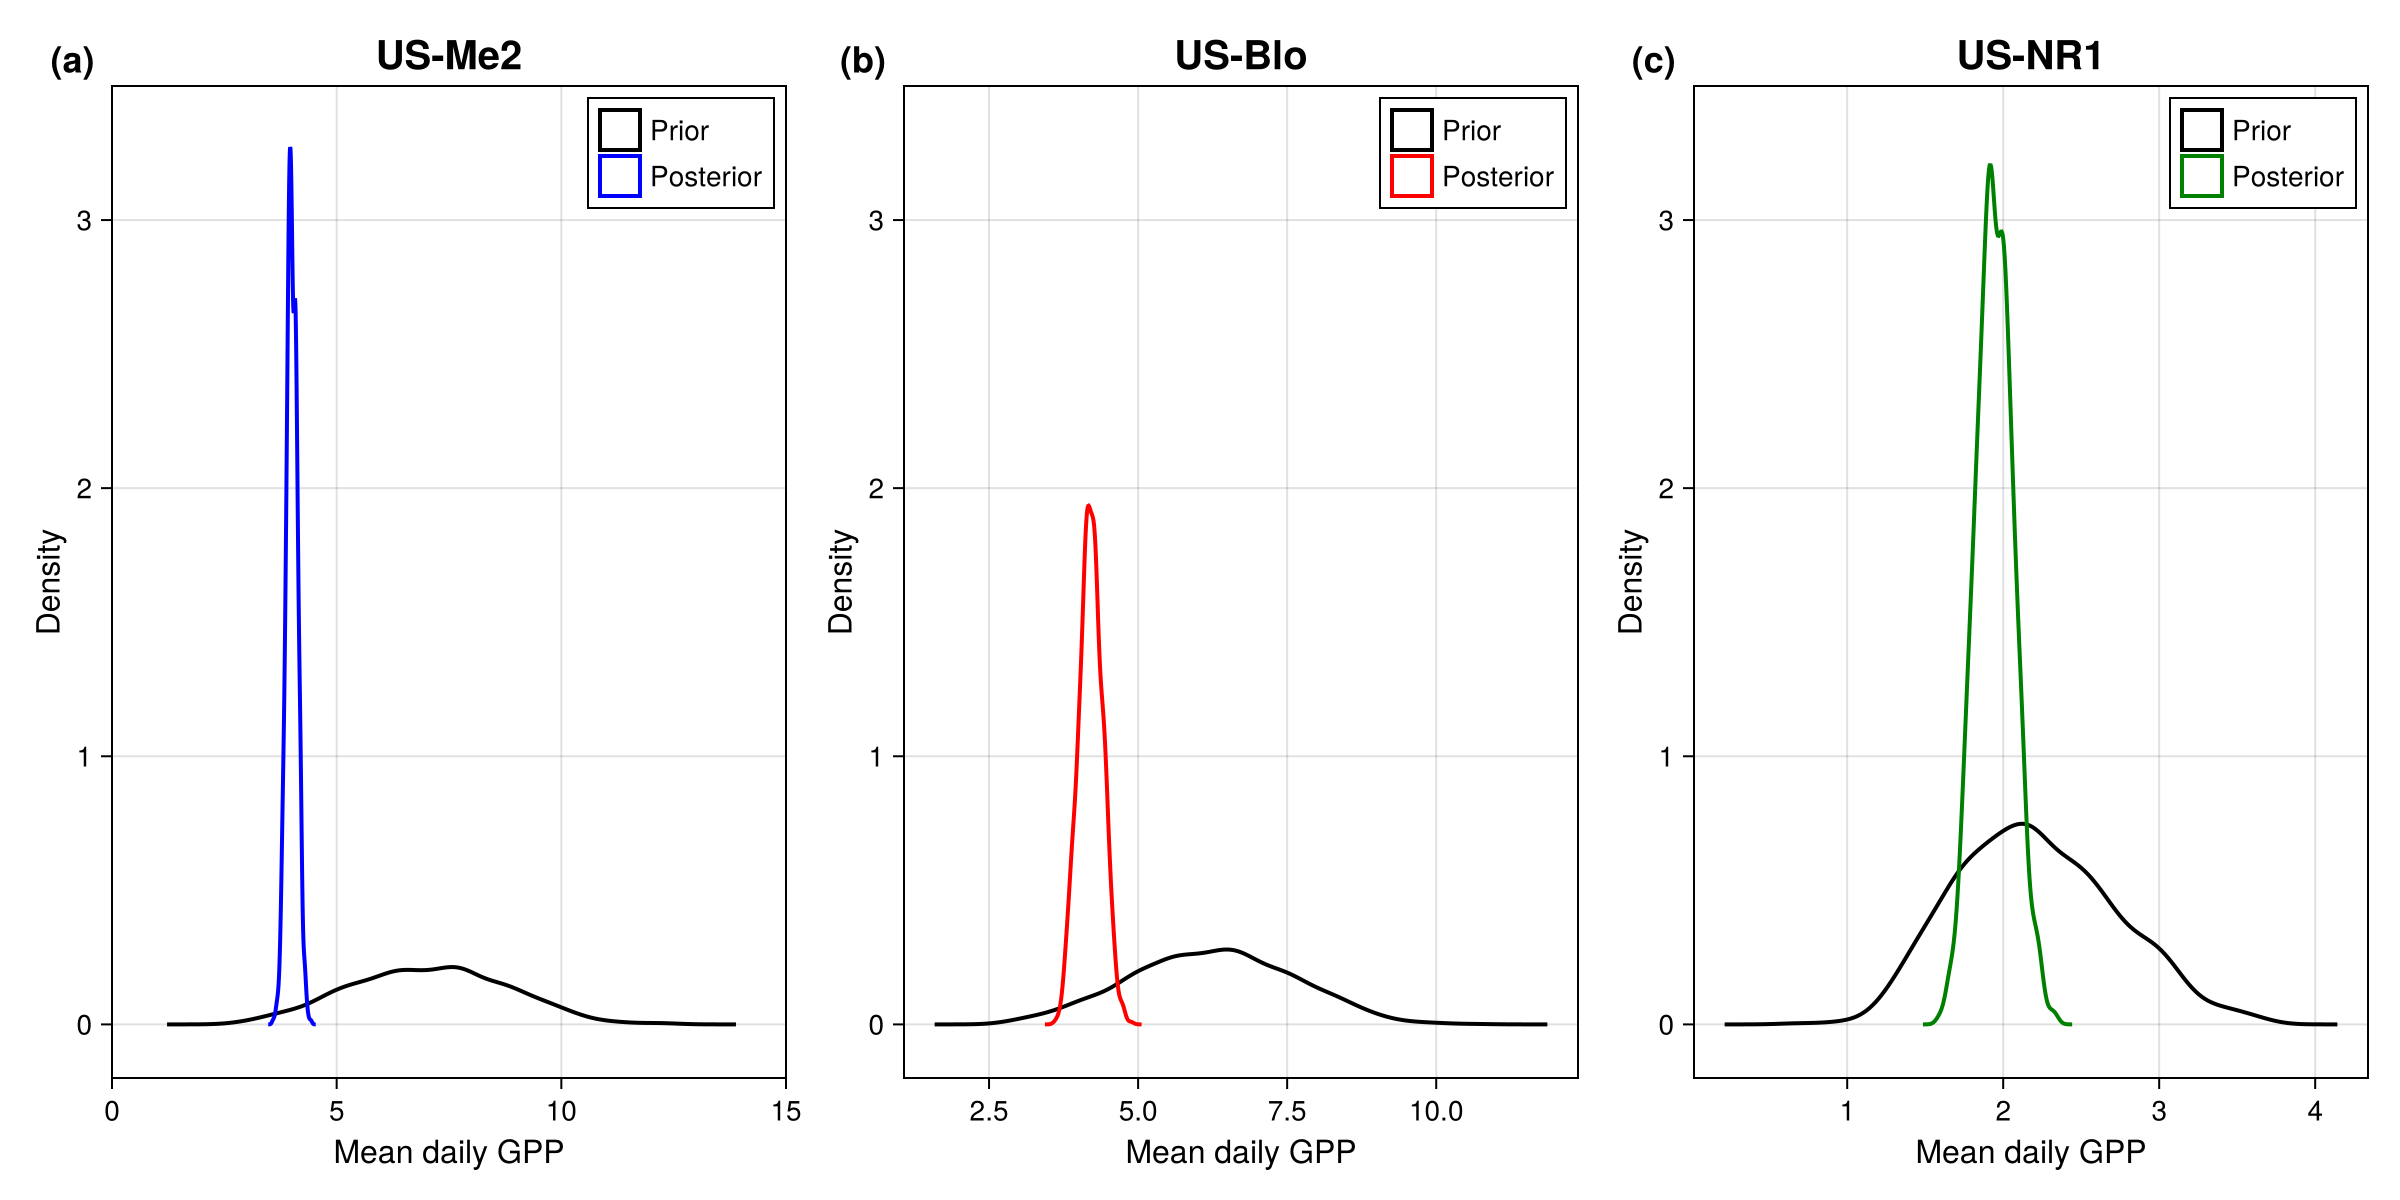

In [54]:
using CairoMakie

# 数据
total_me2        = mean(y_sim_1_1, dims=1) |> vec
total_blo        = mean(y_sim_3_3, dims=1) |> vec
total_nr1        = mean(y_sim_5_5, dims=1) |> vec
total_me2_prior  = mean(y_sim_1_1_prior, dims=1) |> vec
total_blo_prior  = mean(y_sim_3_3_prior, dims=1) |> vec
total_nr1_prior  = mean(y_sim_5_5_prior, dims=1) |> vec

fig = Figure(size=(1200, 600))

# US-Me2
ax1 = Axis(fig[1, 1], xlabel="Mean daily GPP", ylabel="Density", title="US-Me2",titlesize=20, xlabelsize=16, ylabelsize=16)
CairoMakie.density!(ax1, total_me2_prior, color=(:blue,0.0), strokecolor=:black, strokewidth=2, label="Prior")
CairoMakie.density!(ax1, total_me2, color=(:blue,0.0), strokecolor=:blue, strokewidth=2, label="Posterior")
Label(fig[1, 1, TopLeft()], "(a)", fontsize=18, font=:bold)
CairoMakie.ylims!(ax1, -0.2, 3.5) 
CairoMakie.xlims!(ax1, 0, 15)
# US-Blo
ax2 = Axis(fig[1, 2], xlabel="Mean daily GPP", ylabel="Density", title="US-Blo",titlesize=20, xlabelsize=16, ylabelsize=16)
CairoMakie.density!(ax2, total_blo_prior, color=(:red,0.0), strokecolor=:black, strokewidth=2, label="Prior")
CairoMakie.density!(ax2, total_blo, color=(:red,0.0), strokecolor=:red, strokewidth=2, label="Posterior")
Label(fig[1, 2, TopLeft()], "(b)", fontsize=18, font=:bold)
CairoMakie.ylims!(ax2, -0.2, 3.5) 
#CairoMakie.xlims!(ax2, 0, 12)
# US-NR1
ax3 = Axis(fig[1, 3], xlabel="Mean daily GPP", ylabel="Density", title="US-NR1",titlesize=20, xlabelsize=16, ylabelsize=16)
CairoMakie.density!(ax3, total_nr1_prior, color=(:green,0.0), strokecolor=:black, strokewidth=2, label="Prior")
CairoMakie.density!(ax3, total_nr1, color=(:green,0.0), strokecolor=:green, strokewidth=2, label="Posterior")
Label(fig[1, 3, TopLeft()], "(c)", fontsize=18, font=:bold)
CairoMakie.ylims!(ax3, -0.2, 3.5) 
#CairoMakie.xlims!(ax3, 0, 5)

axislegend(ax1; position=:rt)
axislegend(ax2; position=:rt)
axislegend(ax3; position=:rt)
fig


In [59]:
using CairoMakie
save("figS7_20250928.pdf",fig)

CairoMakie.Screen{PDF}


In [88]:
fig = Figure(size= (900, 600));

In [90]:
function sample_observation(sample, model,N_PCA)  
    σ = sample[6] 
    β_1=sample[5]
    p = sample[1:4]
    θ = reshape(p, 1, length(p))
    m = model_1(θ,N_PCA)
    err=a1*randn(length(m))
    y = β_1*m +err
end

sample_observation (generic function with 1 method)

In [92]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp1, model_1, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end

xvalues = [2004, 2006, 2008]
xlabels = ["", "", ""]

# Create figure and axis
#l = fig[1, 1] = GridLayout()
ax1 = Axis(fig[1, 1], xlabel = "", ylabel = "US-Me2",title="US-Me2",xticks=(xvalues, xlabels))
CairoMakie.ylims!(ax1, -5, 15)
# Add plots

p2=band!(ax1, time1[15:10:1805], ci[:, 1], ci[:, 2], color = (:pink, 1))
# Add mean line
p4=lines!(ax1, time1[15:10:1805], GPP_01_be, color = :blue, linewidth = 4, label = "BE+noise")
p3=lines!(ax1, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth = 2, label = "mean")
# Add scatter plots
p5=GLMakie.scatter!(ax1, time1[15:10:1805], GPP_01,  markersize=6,color = :green, label = "FLUXNET")
rmse_value = rmse(GPP_01, y_sim_1_1_m)
text!(ax1, 2003, 13, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
r2 = cor(GPP_01, y_sim_1_1_m)

legend=Legend(fig,[p2,p3,p4,p5], ["95% interval","mean","best estimate","FLUXNET"],tellheight = false, halign =:left, valign =:top, orientation = :horizontal, framevisible = false)
fig[4,2] = legend
legend.width = Relative(1.2)
fig[1,1]=ax1

Axis with 5 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Scatter{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


In [93]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp3, model_1, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end

xvalues = [2004, 2006, 2008]
xlabels = ["", "", ""]

# Create figure and axis

ax2 = Axis(fig[2, 1], xlabel = "", ylabel = "US-Blo", title = "",xticks=(xvalues, xlabels))
CairoMakie.ylims!(ax2, -5, 15)

# Add shaded area
band!(ax2, time1[15:10:1805], ci[:, 1], ci[:, 2],  color = (:pink,1))
# Add mean line
lines!(ax2, time1[15:10:1805], GPP_01_be, color = :blue, linewidth = 4, label = "BE+noise")
lines!(ax2, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth = 2, label = "mean")
GLMakie.scatter!(ax2, time1[15:10:1805], GPP_01, markersize=6,color = :green, label = "")
rmse_value = rmse(GPP_01, y_sim_1_1_m)
text!(ax2, 2003, 13, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
fig[2,1]=ax2


Axis with 5 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Scatter{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


In [94]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp5, model_1, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end

xvalues = [2004, 2006, 2008]
xlabels = ["", "", ""]

# Create figure and axis

ax3 = Axis(fig[3, 1], xlabel = "year", ylabel = "US-NR1", title = "")
CairoMakie.ylims!(ax3, -5, 15)

# Add shaded area
band!(ax3, time1[15:10:1805], ci[:, 1], ci[:, 2],  color = (:pink, 1))
# Add mean line
lines!(ax3, time1[15:10:1805], GPP_01_be, color = :blue, linewidth = 4, label = "BE+noise")
lines!(ax3, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth = 2, label = "mean")
GLMakie.scatter!(ax3, time1[15:10:1805], GPP_01, markersize=6,color = :green, label = "")
rmse_value = rmse(GPP_01, y_sim_1_1_m)
text!(ax3, 2003, 13, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
fig[3,1]=ax3


Axis with 5 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Scatter{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


In [98]:
function sample_observation(sample, model,N_PCA)  
    σ = sample[6] 
    β_1=sample[5]
    p = sample[1:4]
    θ = reshape(p, 1, length(p))
    m = model_3(θ,N_PCA)
    err=a3*randn(length(m))
    y = β_1*m +err
end

sample_observation (generic function with 1 method)

In [100]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp1, model_3, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end
# Create figure and axis
xvalues = [2004, 2006, 2008]
xlabels = ["", "", ""]

ax4 = Axis(fig[1, 2], xlabel = "", ylabel = "", title = "US-Blo",xticks=(xvalues, xlabels))
CairoMakie.ylims!(ax4, -5, 15)

# Add shaded area
band!(ax4, time1[15:10:1805], ci[:, 1], ci[:, 2], color = (:pink,1))
# Add mean line
lines!(ax4, time1[15:10:1805], GPP_03_be, color = :blue, linewidth = 4, label = "BE+noise")
lines!(ax4, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth =2, label = "mean")
GLMakie.scatter!(ax4, time1[15:10:1805], GPP_03, markersize=6,color = :green, label = "")
rmse_value = rmse(GPP_03, y_sim_1_1_m)
text!(ax4, 2003, 13, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
fig[1,2]=ax4

Axis with 5 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Scatter{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


In [101]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp3, model_3, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end

xvalues = [2004, 2006, 2008]
xlabels = ["", "", ""]

# Create figure and axis

ax5 = Axis(fig[2, 2], xlabel = "", ylabel = "", title="",xticks=(xvalues, xlabels))
CairoMakie.ylims!(ax5, -5, 15)

# Add shaded area
band!(ax5, time1[15:10:1805], ci[:, 1], ci[:, 2],  color = (:pink,1))
# Add mean line
lines!(ax5, time1[15:10:1805], GPP_03_be, color = :blue, linewidth = 4, label = "BE+noise")
lines!(ax5, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth =2, label = "mean")
GLMakie.scatter!(ax5, time1[15:10:1805], GPP_03,markersize=6, color = :green, label = "")
rmse_value = rmse(GPP_03, y_sim_1_1_m)
text!(ax5, 2003, 13, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
fig[2,2]=ax5


Axis with 5 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Scatter{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


In [102]:
y_sim_1_1 = simulate_observations(180, p_samp5, model_3, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end

xvalues = [2004, 2006, 2008]
xlabels = ["", "", ""]

# Create figure and axis

ax6= Axis(fig[3, 2], xlabel =  "year", ylabel = "", title = "")
CairoMakie.ylims!(ax6, -5, 15)

# Add shaded area
band!(ax6, time1[15:10:1805], ci[:, 1], ci[:, 2], color = (:pink,1))
# Add mean line
lines!(ax6, time1[15:10:1805], GPP_03_be, color = :blue, linewidth = 4, label = "BE+noise")
lines!(ax6, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth =2, label = "mean")
GLMakie.scatter!(ax6, time1[15:10:1805], GPP_03,markersize=6, color = :green, label = "")
rmse_value = rmse(GPP_03, y_sim_1_1_m)
text!(ax6, 2003, 13, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
fig[3,2]=ax6


Axis with 5 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Scatter{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


In [103]:
function sample_observation(sample, model,N_PCA)  
    σ = sample[6] 
    β_1=sample[5]
    #β_0=sample[5]
    p = sample[1:4]
    θ = reshape(p, 1, length(p))
    m = model_5(θ,N_PCA)
    err=a5*randn(length(m))
    y = β_1*m +err
end

sample_observation (generic function with 1 method)

In [105]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp1, model_5, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end
xvalues = [2004, 2006, 2008]
xlabels = ["", "", ""]

# Create figure and axis

ax7 = Axis(fig[1,3], xlabel = "", ylabel = "", title = "US-NR1",xticks=(xvalues, xlabels))
CairoMakie.ylims!(ax7, -5, 15)
# Add shaded area
band!(ax7, time1[15:10:1805], ci[:, 1], ci[:, 2],  color = (:pink, 1))
# Add mean line
lines!(ax7, time1[15:10:1805], GPP_05_be, color =  :blue, linewidth = 4, label = "BE+noise")
lines!(ax7, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth = 2, label = "mean")
GLMakie.scatter!(ax7, time1[15:10:1805], GPP_05,markersize=6, color = :green, label = "")
rmse_value = rmse(GPP_05, y_sim_1_1_m)
text!(ax7, 2003, 13, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
fig[1,3]=ax7


Axis with 5 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Scatter{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


In [106]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp3, model_5, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end

xvalues = [2004, 2006, 2008]
xlabels = ["", "", ""]

# Create figure and axis

ax8 = Axis(fig[2,3], xlabel = "", ylabel = "", title = "",xticks=(xvalues, xlabels))
CairoMakie.ylims!(ax8, -5, 15)

# Add shaded area
band!(ax8, time1[15:10:1805], ci[:, 1], ci[:, 2],  color = (:pink, 1))
# Add mean line
lines!(ax8, time1[15:10:1805], GPP_05_be, color = :blue, linewidth = 4, label = "BE+noise")
lines!(ax8, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth = 2, label = "mean")
GLMakie.scatter!(ax8, time1[15:10:1805], GPP_05,markersize=6, color = :green, label = "")
rmse_value = rmse(GPP_05, y_sim_1_1_m)
text!(ax8, 2003, 13, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
fig[2,3]=ax8

Axis with 5 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Scatter{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


In [108]:
# Simulate observations
y_sim_1_1 = simulate_observations(180, p_samp5, model_5, 12)
y_sim_1_1_m = mean(y_sim_1_1, dims=2)
ci = zeros(Float64, 180, 2)
for i = 1:size(y_sim_1_1, 1)
    ci[i, :] .= confidence_interval(y_sim_1_1[i, :])
end

xvalues = [2004, 2006, 2008]
xlabels = ["", "", ""]

# Create figure and axis

ax9 = Axis(fig[3, 3], xlabel = "year", ylabel = "",title="")
CairoMakie.ylims!(ax9, -5, 15)
# Add shaded area
band!(ax9, time1[15:10:1805], ci[:, 1], ci[:, 2],  color = (:pink,1))
# Add mean line
lines!(ax9, time1[15:10:1805], GPP_05_be, color = :blue, linewidth = 4, label = "BE+noise")
lines!(ax9, time1[15:10:1805],vec(y_sim_1_1_m), color = :red, linewidth = 2, label = "mean")
GLMakie.scatter!(ax9, time1[15:10:1805], GPP_05,markersize=6, color = :green, label = "")
rmse_value = rmse(GPP_05, y_sim_1_1_m)
text!(ax9, 2003, 13, text= string("NRMSE=",round(rmse_value, digits=2)), align = (:left, :center))
fig[3,3]=ax9

Axis with 5 plots:
 ┣━ Band{Tuple{Vector{Point{2, Float64}}, Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Lines{Tuple{Vector{Point{2, Float64}}}}
 ┣━ Scatter{Tuple{Vector{Point{2, Float64}}}}
 ┗━ Makie.Text{Tuple{Vector{Point{2, Float64}}}}


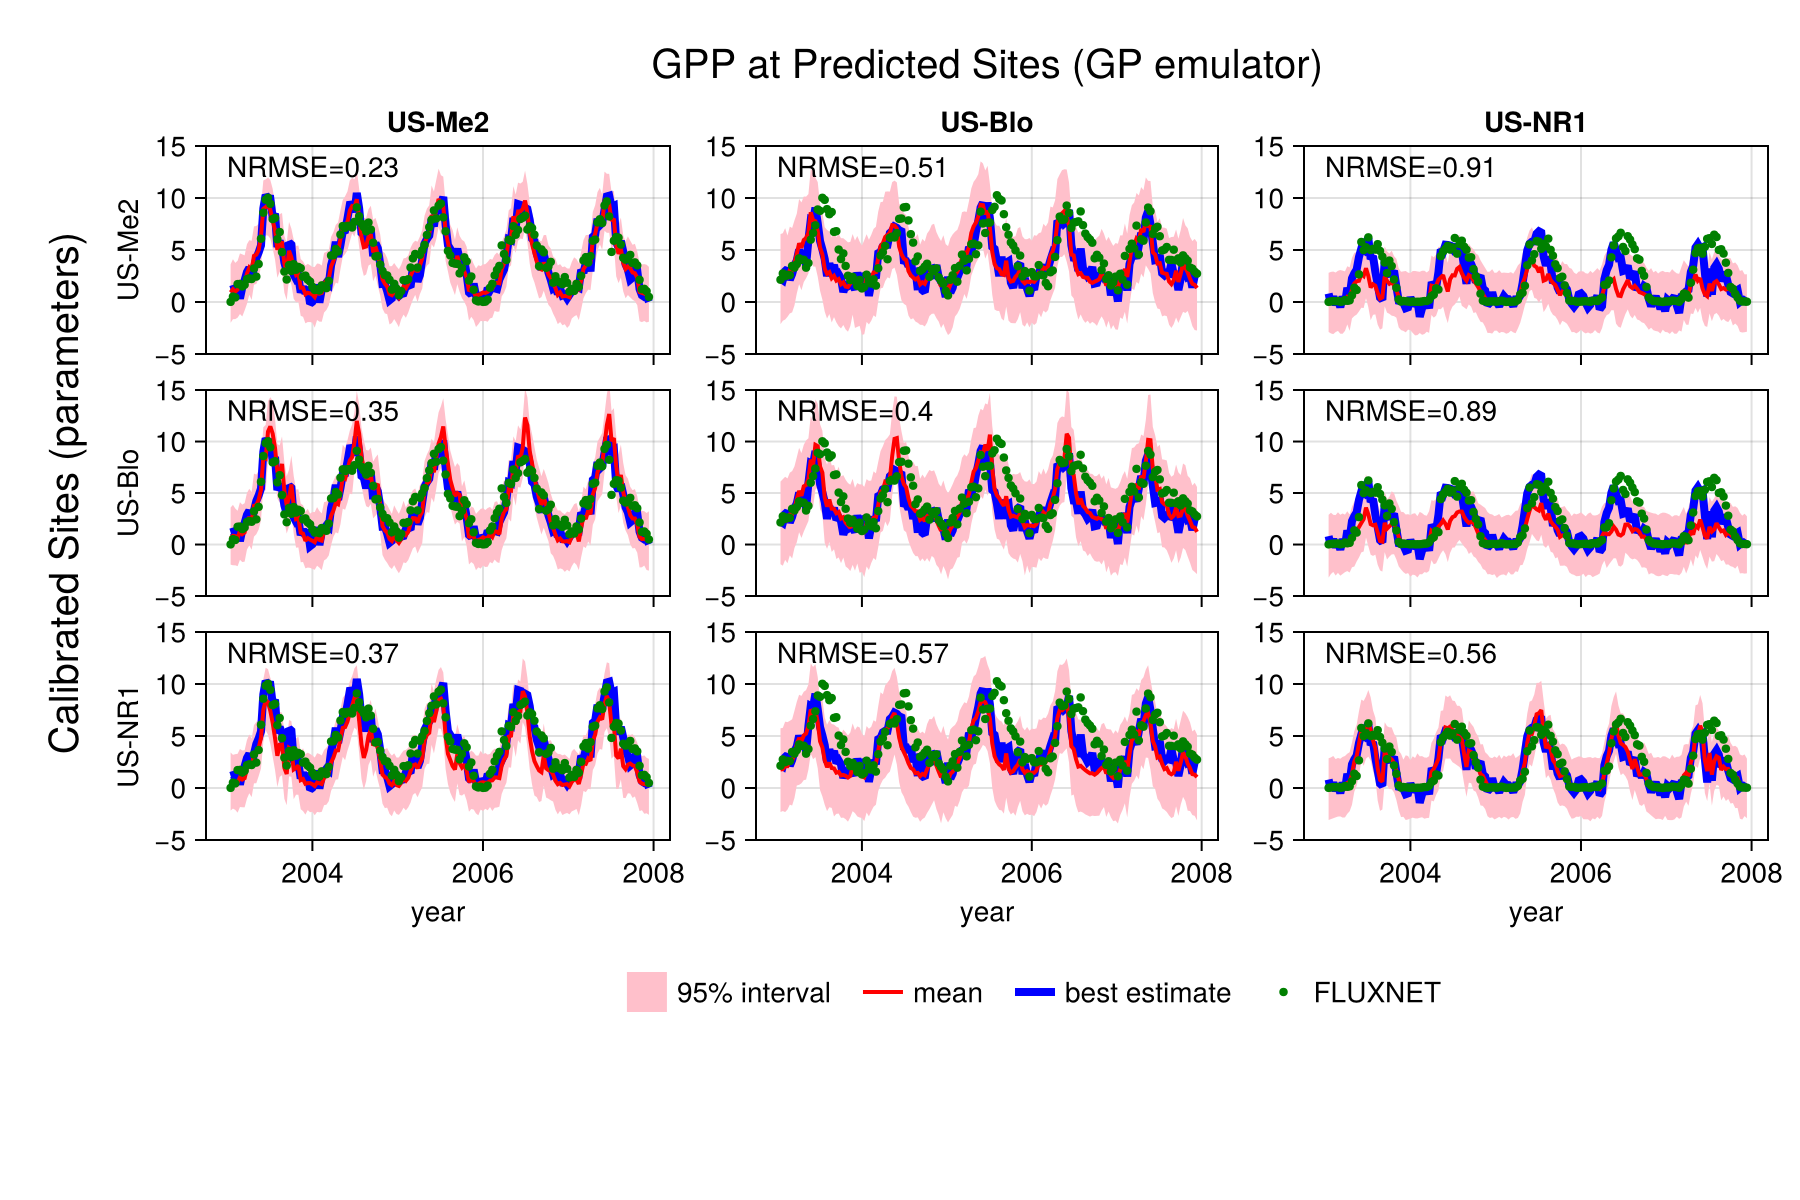

In [109]:
Label(fig[1,2,Top()], "GPP at Predicted Sites (GP emulator)", fontsize=20, padding=(4, 4, 30, 4))
Label(fig[2,1,Left()], "Calibrated Sites (parameters)", rotation=π/2, fontsize=20, padding=(4, 60, 4, 4))
fig

In [116]:
using CairoMakie
save("fig9_site_3_3_fluxnet_nobeta0_20250928_markersize6.pdf",fig)

CairoMakie.Screen{PDF}
